In [24]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import h5py
from scipy.optimize import curve_fit

In [10]:
# Given data
Ux_data = "1.19373163630095 0.0921976399488268 0.807664179809399 0.379721034467220 0.204834018666297 0.0959562069736421 0.0155029957938934 0.146745364195376 0.365912650515842 0.537472206373203 0.0225836566492411 -0.00803149124979970 -0.0545997344242642 -0.225153553264390 0.115553562829737 -0.116948287236155 0.00951054404980936 0.0676047883411229 -0.204282483198040 0.106077826227993 -0.224730803943385 0.303336952663958 -0.193342328575745 0.494213930192604 -0.174832823107135"
Uy_data = "-1.44450783194133 -1.36836991542678 -0.982782372990096 -0.874078956395388 -0.518555954005569 -0.326492859162390 -0.241227701182372 -0.0836239763826597 -0.00643065226697940 0.0201931967788096 0.0486825602517564 0.109610849618912 0.499902631840086 1.12319124814166 -0.291266587602440 0.307770183346002 0.265646888866162 0.258388271254371 0.357106482705858 -0.188527031168342 0.571057567863500 -0.212480249218643 0.462355502046193 0.182495783783212 0.437427041939372"
k_data = "0.0380799109526036 0.0507732146034714 0.0634665182543393 0.0761598219052071 0.0888531255560750 0.101546429206943 0.114239732857811 0.126933036508679 0.139626340159546 0.152319643810414 0.165012947461282 0.177706251112150 0.190399554763018 0.203092858413886 0.215786162064753 0.228479465715621 0.241172769366489 0.253866073017357 0.266559376668225 0.279252680319093 0.291945983969961 0.304639287620828 0.317332591271696 0.330025894922564 0.342719198573432"

# Convert the string data to arrays
Ux_matlab = np.fromstring(Ux_data, sep=' ')
Uy_matlab = np.fromstring(Uy_data, sep=' ')
k_matlab = np.fromstring(k_data, sep=' ')

Text(0.5, 1.0, 'Matlab Effective Current $|U|$')

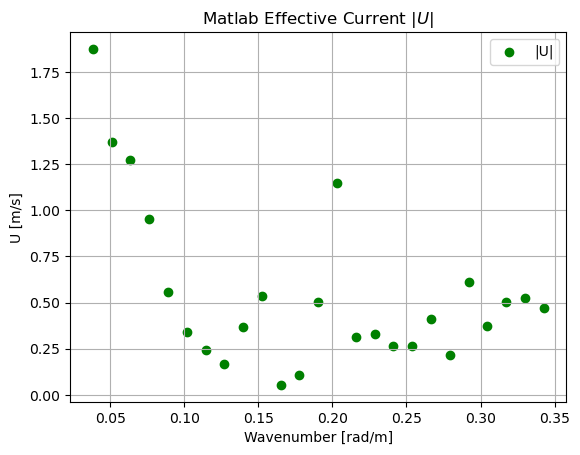

In [11]:
plt.scatter(k_matlab, np.sqrt(Ux_matlab**2+Uy_matlab**2), label='|U|', color = 'green')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title('Matlab Effective Current $|U|$')

In [12]:
Ux = Ux_matlab
Uy = Uy_matlab
wavenumbers = k_matlab

In [13]:
filtered_x = wavenumbers
filtered_y = np.sqrt(Ux**2+Uy**2)

In [14]:
filtered_x = np.insert(filtered_x, 0, 1e-8)
filtered_y = np.insert(filtered_y, 0, 1e-8)

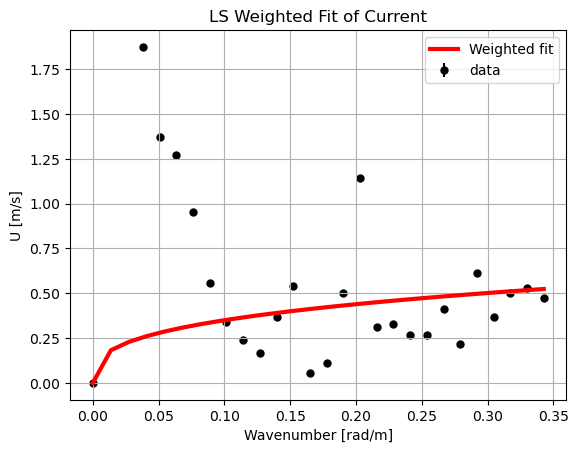

In [17]:
def fpow(x, a, b):
    return a * x**b 

def custom_weights(x):
    weights = np.ones_like(x)  # default weight for all points
    weights[(0 < x) & (x <= 0.2)] = 0.2  # medium error for 0 < x <= 0.2
    weights[x > 0.2] = 0.1  # low error for x > 0.15
    weights[np.isclose(x, 0, atol=1e-8)] = 0.001  # very low error for x = 0
    return weights

# initial guess
pars0 = (0.4, 0.4)

# perform fitting with custom weights
popt, pcov = curve_fit(fpow, filtered_x, filtered_y, absolute_sigma=True, p0=pars0, sigma=custom_weights(filtered_x), maxfev=5000)

# parameters
a_opt = popt[0]
b_opt = popt[1]

# plot data
plt.errorbar(filtered_x, filtered_y, yerr=0, fmt =".", color='black', label ='data', zorder=1, markersize=10)

# creating x interval to include in y fit
x_interval = np.linspace(0, max(filtered_x), len(filtered_x))
y_fit = fpow( x_interval , *popt)
plt.plot( x_interval, y_fit, color = "red", label = "Weighted fit", zorder=2 , linewidth=3)

plt.grid(True)
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS Weighted Fit of Current")
plt.legend()
plt.show()

In [2]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1

                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

In [20]:
pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])

C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarning: Polyfit may be poorly conditioned
  pEDM = np.polyfit(zEx, cTilEx, nMax)
C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarning: Polyfit may be poorly conditioned
  pEDM = np.polyfit(zEx, cTilEx, nMax)
C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarning: Polyfit may be poorly conditioned
  pEDM = np.polyfit(zEx, cTilEx, nMax)
C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarning: Polyfit may be poorly conditioned
  pEDM = np.polyfit(zEx, cTilEx, nMax)
C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarning: Polyfit may be poorly conditioned
  pEDM = np.polyfit(zEx, cTilEx, nMax)
C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarning: Polyfit may be poorly conditioned
  pEDM = np.polyfit(zEx, cTilEx, nMax)
C:\Users\josep\AppData\Local\Temp\ipykernel_16916\4042271757.py:65: RankWarn

In [21]:
z = np.linspace(-20, 0, 100)
U1_fun = lambda z: np.polyval(pPEDM1, z)

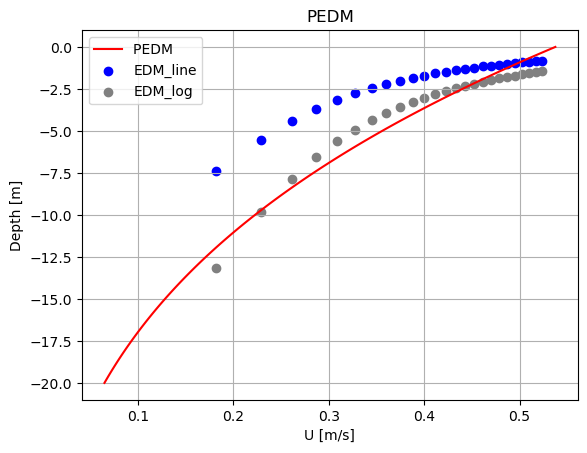

In [22]:
plt.plot(U1_fun(z), z, label="PEDM ", color = 'red')

plt.scatter( y_fit[1:],-1/(3.56*wavenumbers), label='EDM_line', color = 'blue')
plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM_log', color = 'grey')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

In [25]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_19_01_22_04.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z = np.array(hf['z_vec'])
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)

(-20.0, 0.0)

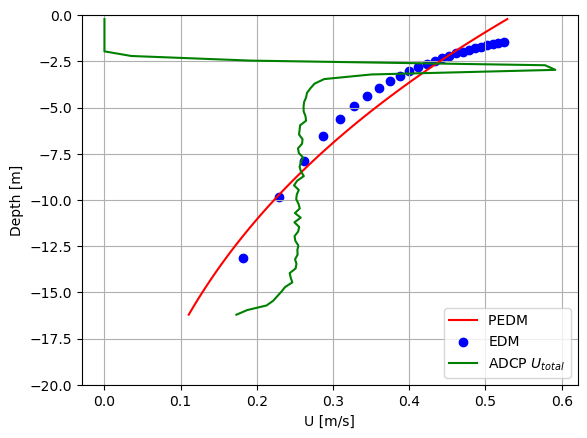

In [27]:
plt.plot(U1_fun(z), z, label="PEDM ", color = 'red')
plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM', color = 'blue')

U = np.sqrt(north_vel_mean**2+east_vel_mean**2)
plt.plot(U, z, label='ADCP $U_{total}$', color = 'green')

plt.grid(True)
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

plt.ylim(-20,0)